In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join as oj

In [102]:
# get all of the dataids in results
dataids = []
for filename in os.listdir('results/regression/newridge'):
    # get last six characters of filename
    id = filename[6:]
    dataids.append(filename[6:])
dataids

['361267',
 '361255',
 '361618',
 '361252',
 '361258',
 '361260',
 '361236',
 '361264',
 '361256',
 '361251',
 '361616',
 '361269',
 '361235',
 '361242',
 '361237',
 '361272',
 '361259',
 '361253',
 '361261',
 '361621',
 '361266',
 '361619',
 '361254',
 '361247',
 '361249',
 '361243',
 '361617',
 '361250',
 '361268',
 '361257',
 '361244']

In [103]:
# set the path we want to look at
seeds = np.arange(1, 3, 1)
metric = "rmse"
pipeline = 2
clustertype = "hierarchical"
# paths = []
# for dataid in dataids:
#     for seed in seeds:
#         paths.append(oj("results", f"dataid{dataid}", f"seed{seed}", f"{metric}", str(clustertype)))

In [104]:
data_results = []
for dataid in dataids:
    data_result = []
    for seed in seeds:
        path = oj("results", "regression", "newridge", f"dataid{dataid}", f"seed{seed}", f"{metric}", str(clustertype))
        # if path exists
        if not os.path.exists(path):
            continue
        files = os.listdir(path)
        method_results = []
        for file in files:
            if file.endswith(".csv"):
                method_result = pd.read_csv(oj(path, file))
                method_result = method_result.rename(columns={"rmse":file[:-4]})
                method_results.append(method_result)
            seed_result = pd.concat(method_results, axis=1)
            seed_result = seed_result.loc[:,
                                ~seed_result.columns.str.contains('^Unnamed')]
            seed_result = seed_result.loc[:, ~seed_result.columns.duplicated()]
        # if dataid == "361618":
        #     # print column of shap
        #     print(seed_result["shap"])
        data_result.append(seed_result)
    # average all of the dataframes in data_result
    if len(data_result) == 0:
        continue
    data_result = sum(data_result) / len(data_result)
    data_results.append(data_result)

In [105]:
len(data_results)

31

In [106]:
# in each data_result, keep only nclust, lmdi_lasso, lmdi_ridge, shap, lime, rawdata
for i in range(len(data_results)):
    data_results[i] = data_results[i][["nclust", "ridge_nonl2_unsigned_nonnormed_noleafavg_norank", "shap", "lime", "rawdata"]]

In [107]:
# for each data_result, only keep the first four rows
# for i in range(len(data_results)):
#     data_results[i] = data_results[i].iloc[0:4]

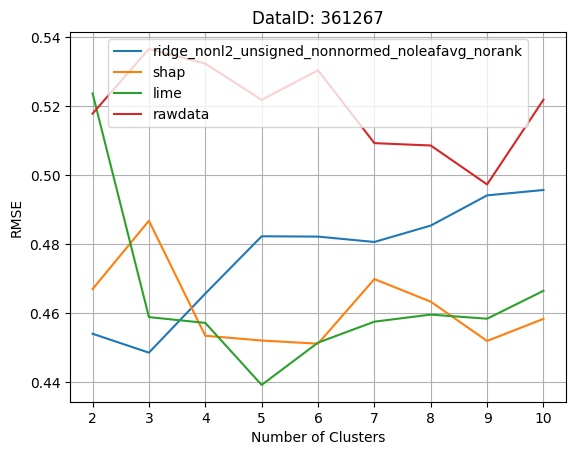

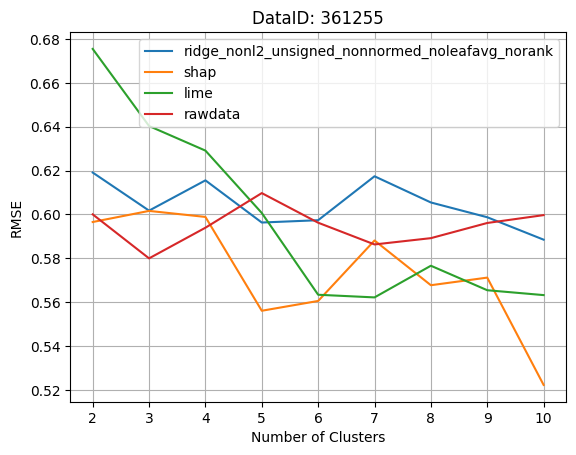

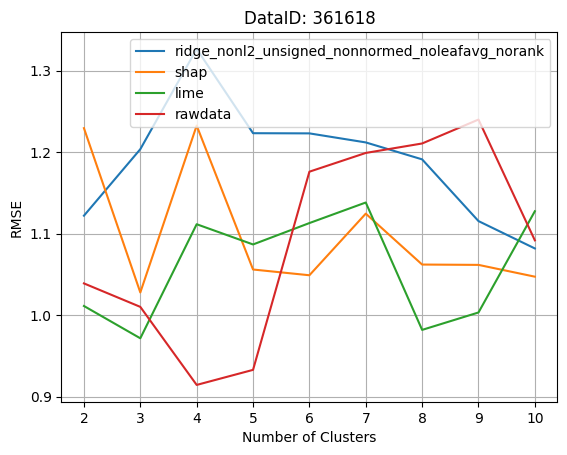

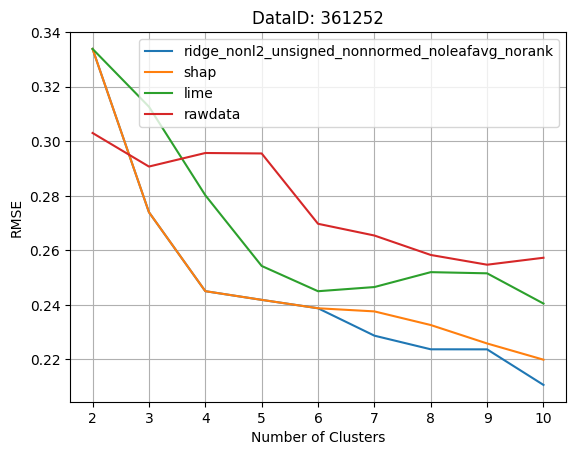

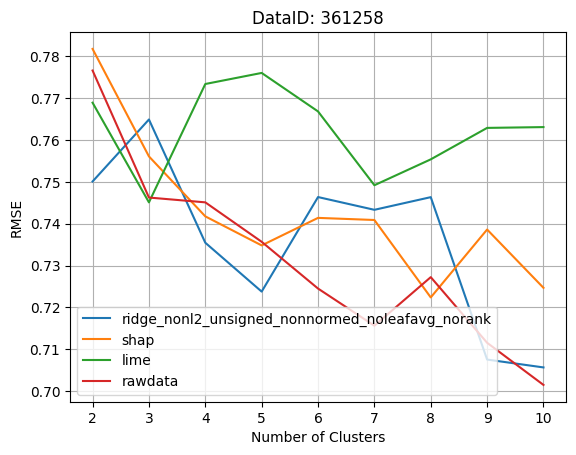

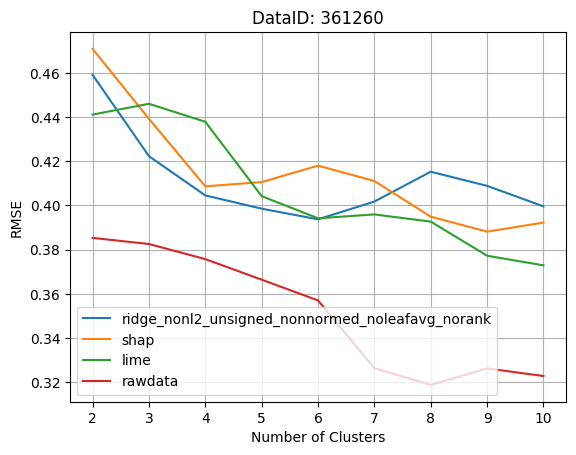

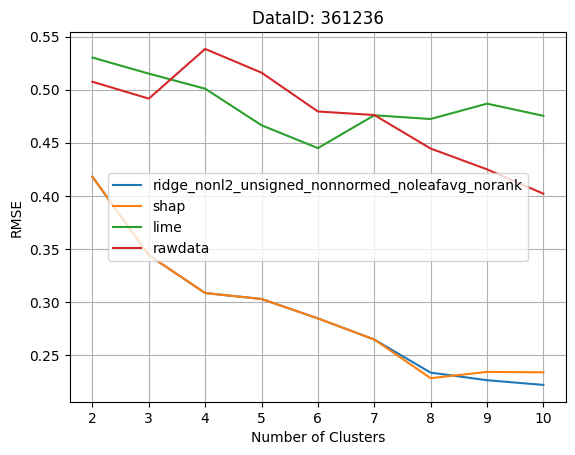

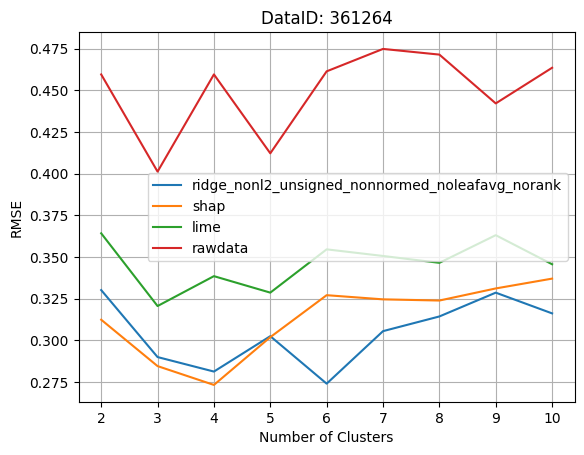

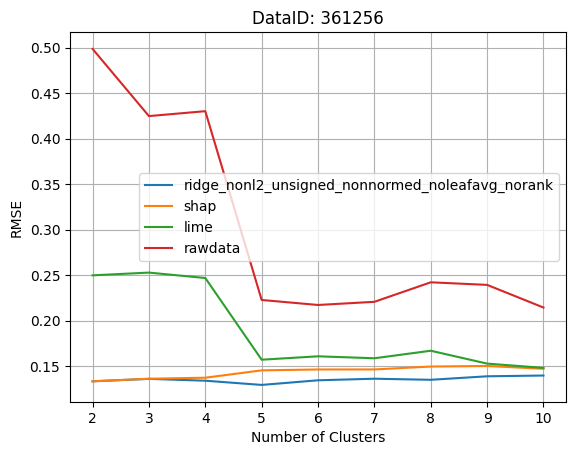

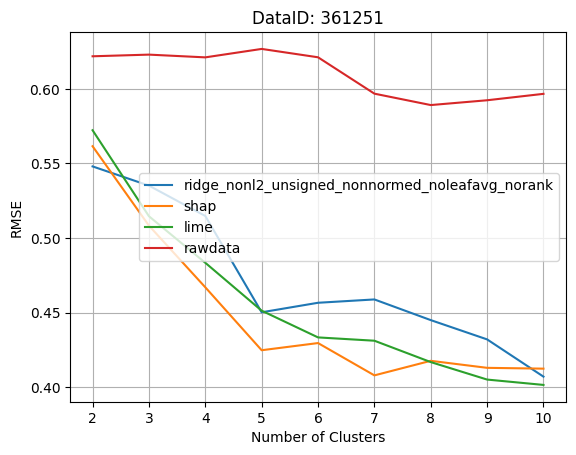

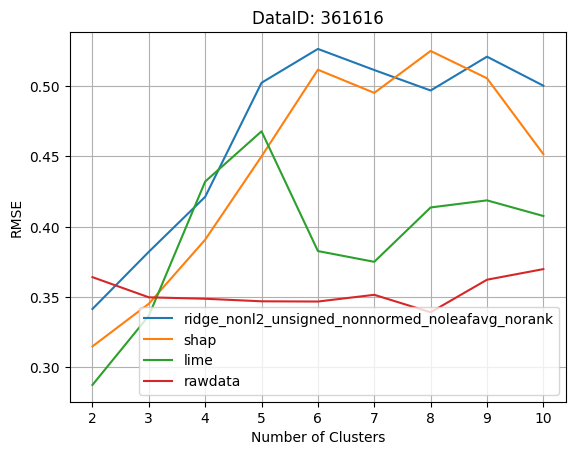

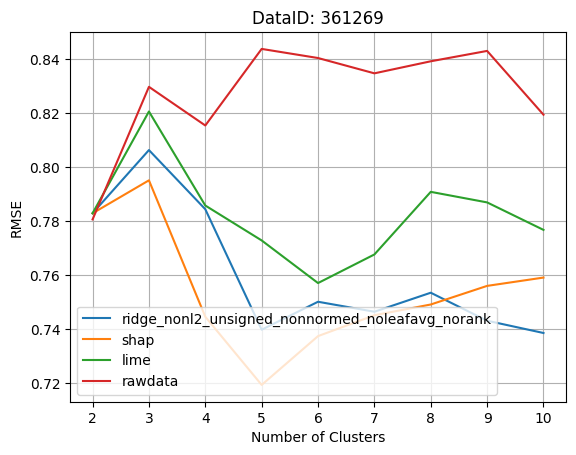

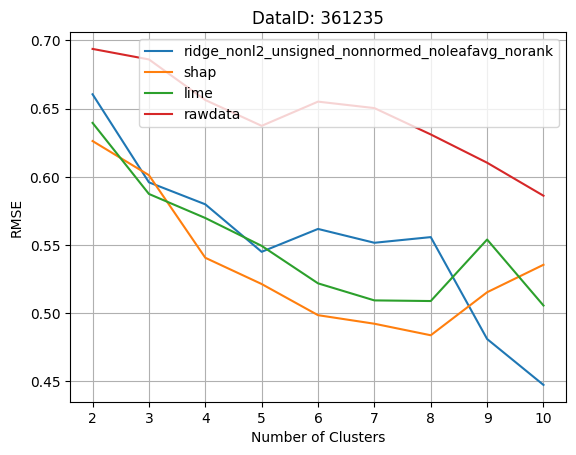

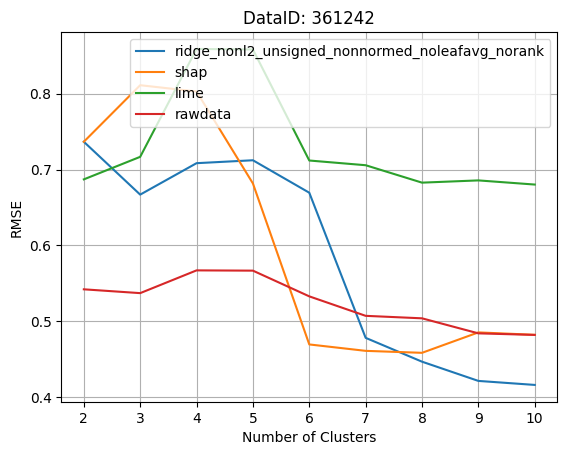

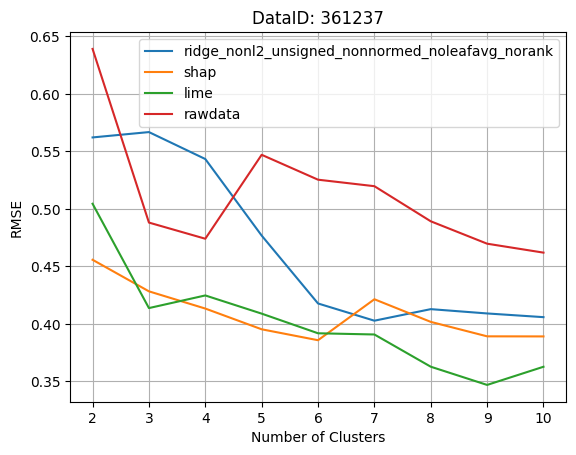

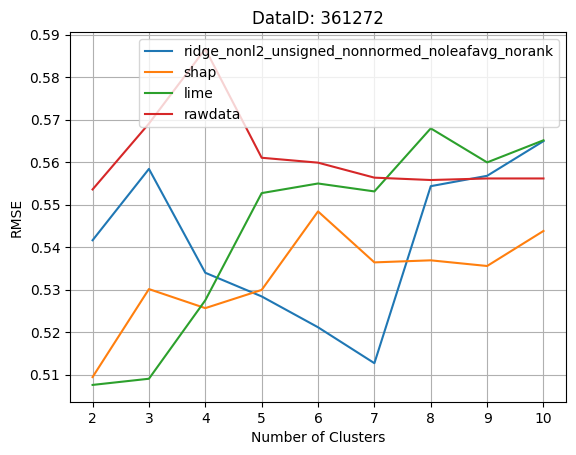

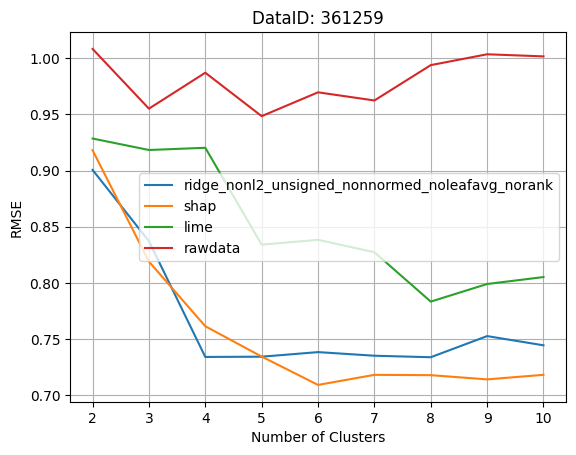

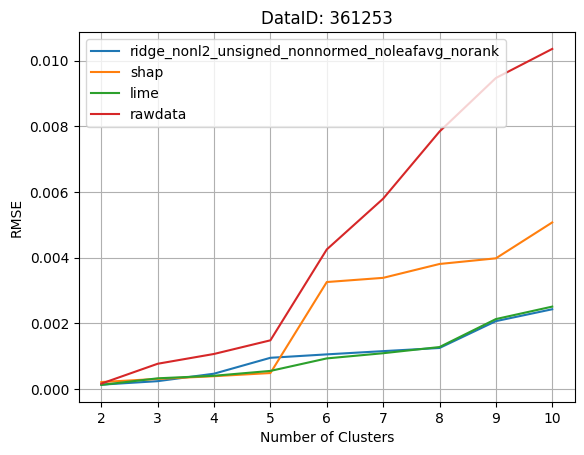

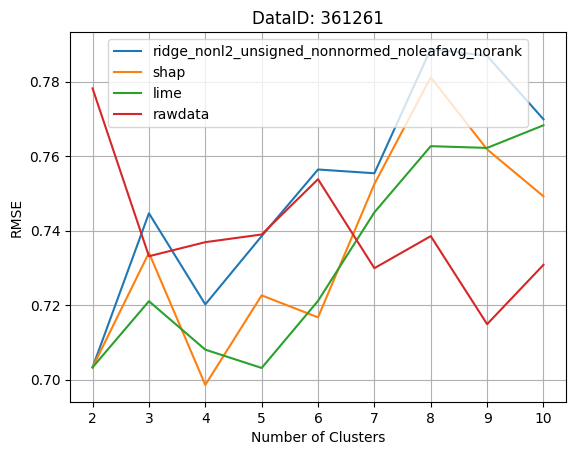

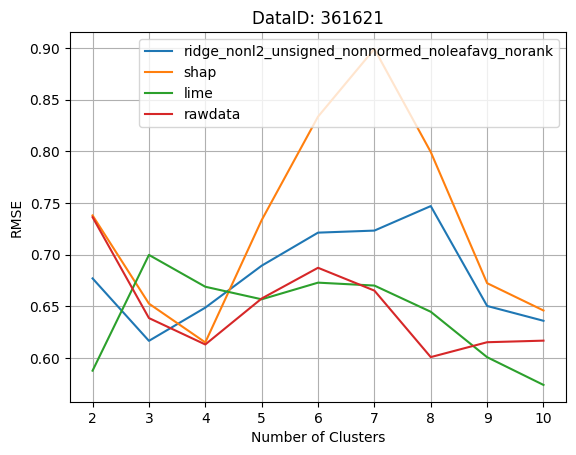

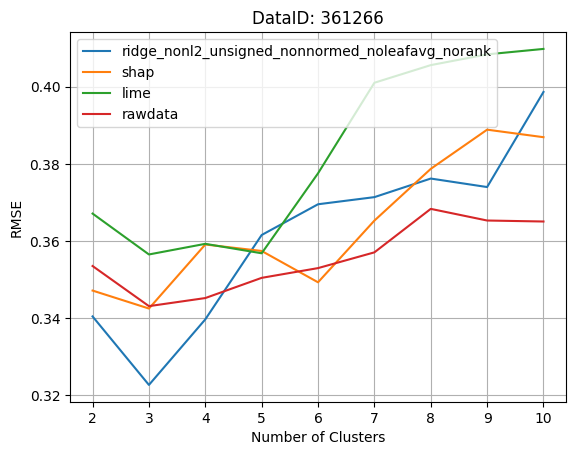

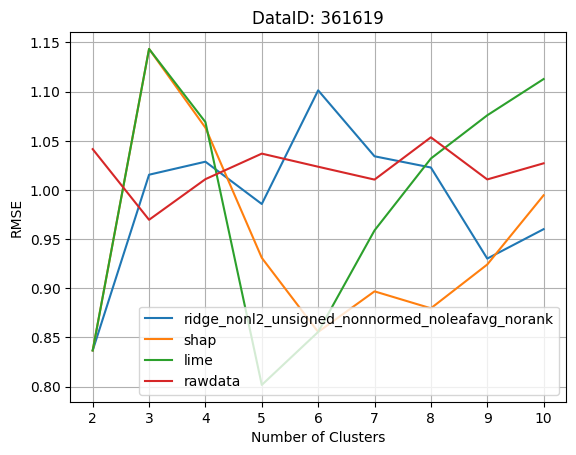

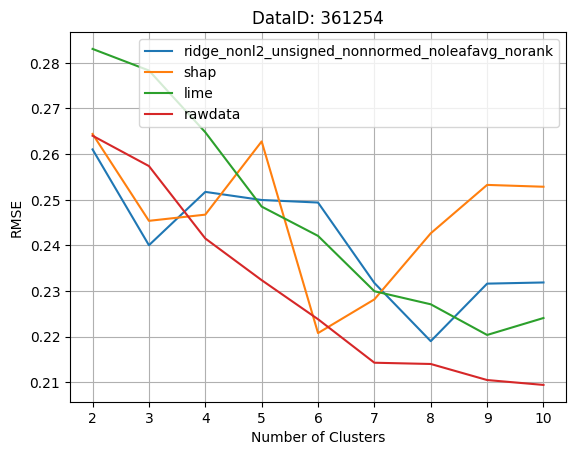

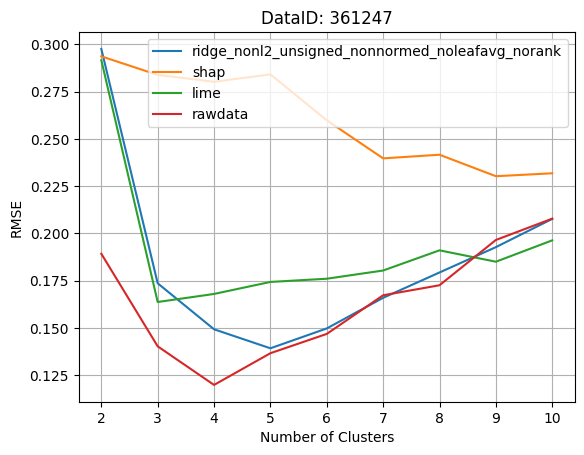

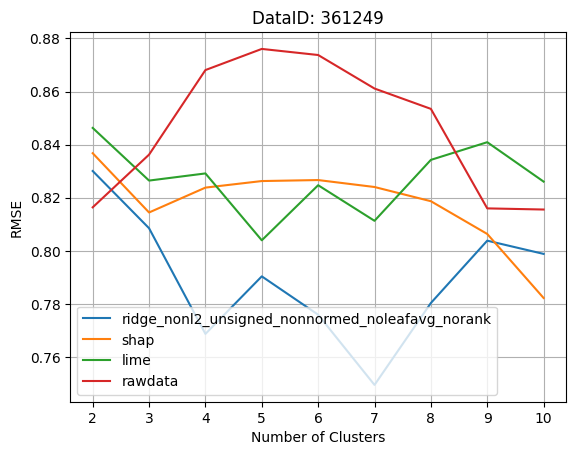

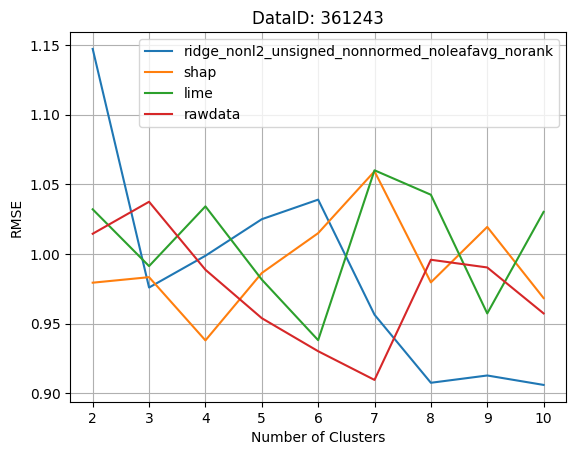

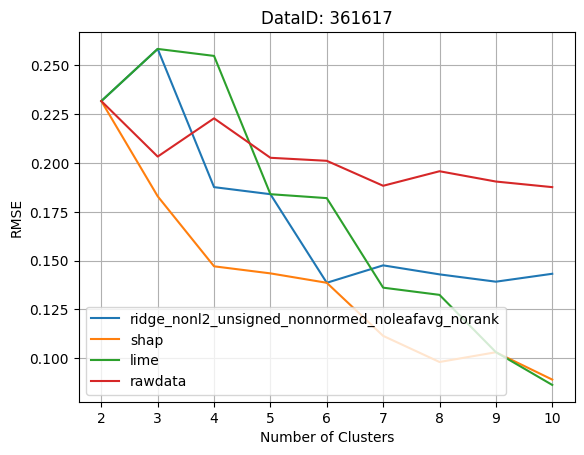

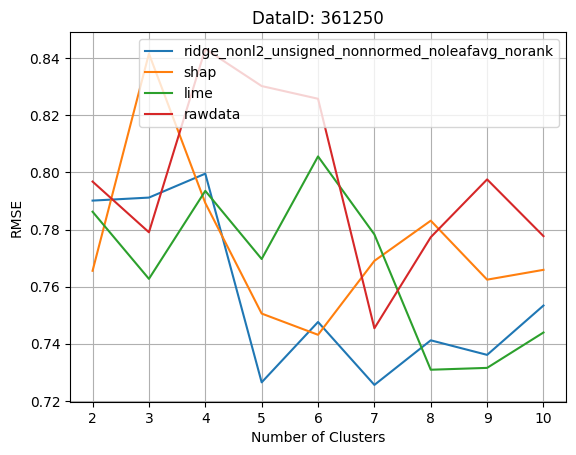

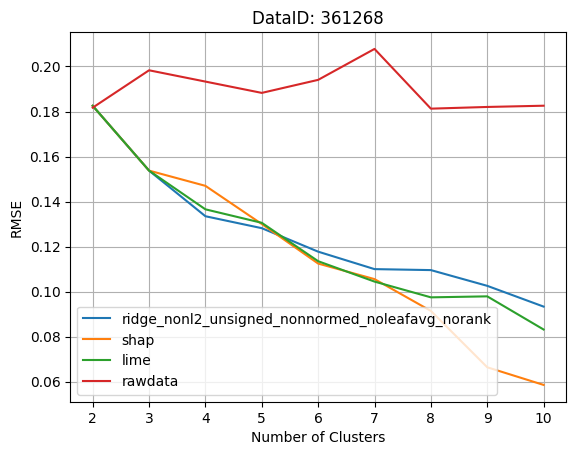

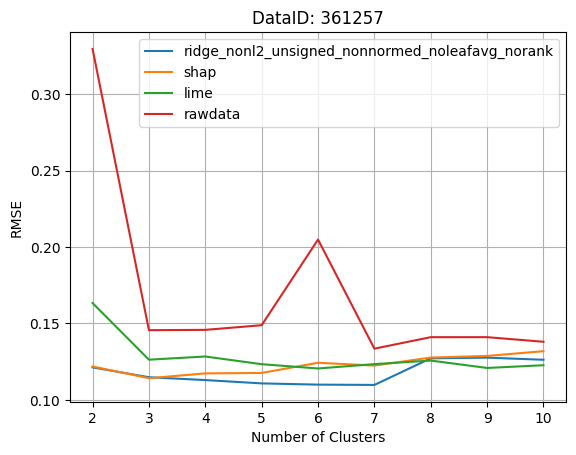

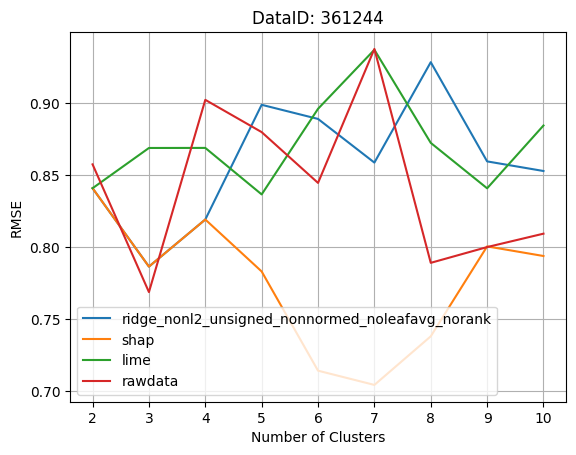

In [108]:
# plot the data, with nclust on x-axis and the rest being lines
i = 0
for data_result in data_results:
    data_result = data_result.set_index("nclust")
    data_result.plot(grid=True)
    # y axis label is RMSE
    plt.ylabel("RMSE")
    # x axis label is number of clusters
    plt.xlabel("Number of Clusters")
    plt.title("DataID: " + dataids[i])
    # move legend to side
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # remove legend
    #plt.legend().remove()
    # show legend
    plt.legend()
    plt.show()
    i+=1


In [109]:
data_results[0]

,nclust,ridge_nonl2_unsigned_nonnormed_noleafavg_norank,shap,lime,rawdata
0,2.0,0.454008,0.466973,0.523753,0.517896
1,3.0,0.448524,0.486802,0.458838,0.536668
2,4.0,0.465664,0.453427,0.457160,0.532402
3,5.0,0.482295,0.452041,0.439161,0.521895
4,6.0,0.482205,0.451133,0.451438,0.530483
5,7.0,0.480644,0.469878,0.457517,0.509326
6,8.0,0.485401,0.463320,0.459567,0.508642
7,9.0,0.494173,0.451919,0.458375,0.497342
8,10.0,0.495729,0.458336,0.466473,0.521932


In [110]:
# plot the data, only shap and aloo_l2_unsigned_nonnormed_leafavg_rank
# i=0
# for data_result in data_results:
#     data_result = data_result.set_index("nclust")
#     data_result[["shap", "nonloo_l2_signed_nonnormed_leafavg_rank"]].plot(grid=True)
#     # move legend to side
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     # call aloo_l2_unsigned_nonnormed_leafavg_rank lmdi+
#     plt.legend(["SHAP", "LMDI+"])
#     # y axis label is RMSE
#     plt.ylabel("RMSE")
#     # x axis label is number of clusters
#     plt.xlabel("Number of Clusters")
#     # title is the dataid
#     plt.title("DataID: " + dataids[i])
#     plt.show()
#     i+=1

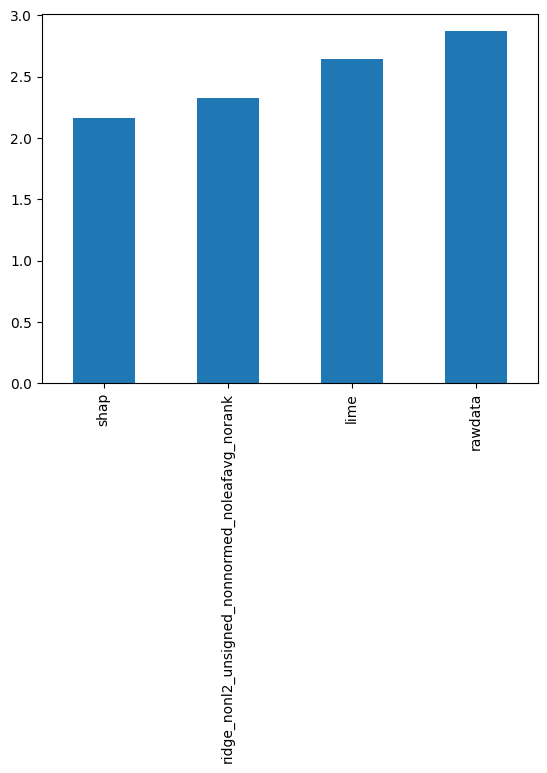

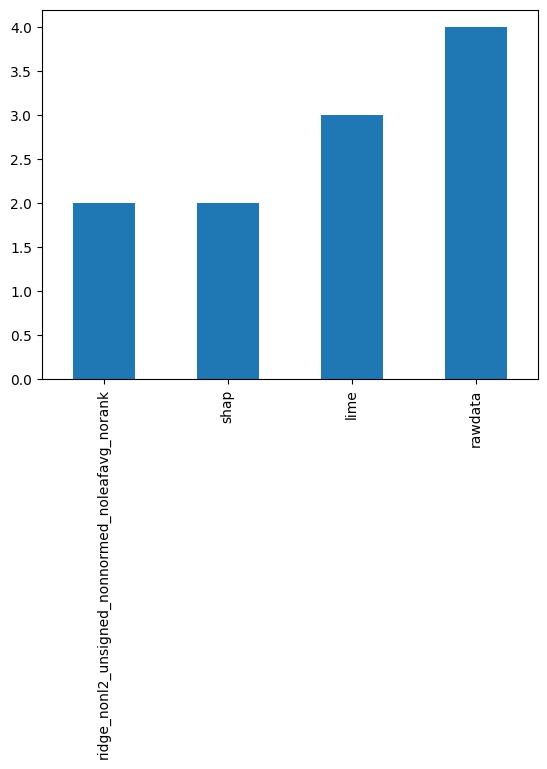

In [111]:
auroc_ranks = []
aurocs = []
points_dict = {}
for data_result in data_results:
    auroc = data_result.drop("nclust", axis=1).apply(np.trapz, x=data_result["nclust"])
    # check if each auroc is higher than shap/lime/rawdata
    for auc_idx in range(len(auroc)):
        if auroc.index[auc_idx] == "shap" or auroc.index[auc_idx] == "lime" or auroc.index[auc_idx] == "rawdata":
            continue
        else:
            # if auroc.index[auc_idx] not in points_dict, add it
            if auroc.index[auc_idx] not in points_dict:
                points_dict[auroc.index[auc_idx]] = 0
            if auroc.iloc[auc_idx] <= auroc["shap"]:
                points_dict[auroc.index[auc_idx]] += 1
            # if auroc.iloc[auc_idx] <= auroc["lime"]:
            #     points_dict[auroc.index[auc_idx]] += 1
            # if auroc.iloc[auc_idx] <= auroc["rawdata"]:
            #     points_dict[auroc.index[auc_idx]] += 1
    aurocs.append(auroc)
    # convert to ranking, i.e. 1 is lowest, 2 is second lowest, etc.
    auroc_rank = auroc.rank()
    auroc_ranks.append(auroc_rank)
# merge series in auroc_ranks by averaging the ranks corresponding to the same names
auroc_ranks = pd.concat(auroc_ranks, axis=1)
auroc_ranks_mean = auroc_ranks.mean(axis=1)
auroc_ranks_median = auroc_ranks.median(axis=1)
auroc_ranks_mean = auroc_ranks_mean.sort_values()
auroc_ranks_median = auroc_ranks_median.sort_values()
auroc_ranks_mean.plot(kind="bar")
plt.show()
auroc_ranks_median.plot(kind="bar")
plt.show()

In [112]:
points_dict

{'ridge_nonl2_unsigned_nonnormed_noleafavg_norank': 16}

In [113]:
sum(aurocs)

ridge_nonl2_unsigned_nonnormed_noleafavg_norank    128.100517
shap                                               126.130614
lime                                               130.790943
rawdata                                            135.750792
dtype: float64

In [114]:
auroc_ranks

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
ridge_nonl2_unsigned_nonnormed_noleafavg_norank,3.0,4.0,4.0,1.0,2.0,3.0,1.0,1.0,1.0,3.0,...,3.0,2.0,2.0,1.0,2.0,2.0,1.0,3.0,1.0,3.0
shap,2.0,1.0,3.0,2.0,3.0,4.0,2.0,2.0,2.0,1.0,...,1.0,3.0,4.0,2.0,3.0,1.0,3.0,1.0,2.0,1.0
lime,1.0,3.0,1.0,3.0,4.0,2.0,4.0,3.0,3.0,2.0,...,2.0,4.0,3.0,3.0,4.0,3.0,2.0,2.0,3.0,4.0
rawdata,4.0,2.0,2.0,4.0,1.0,1.0,3.0,4.0,4.0,4.0,...,4.0,1.0,1.0,4.0,1.0,4.0,4.0,4.0,4.0,2.0


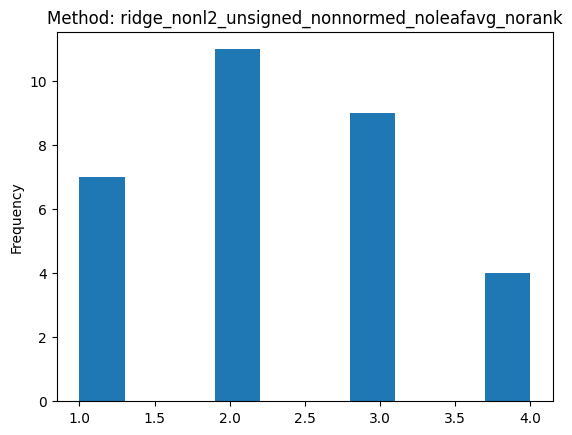

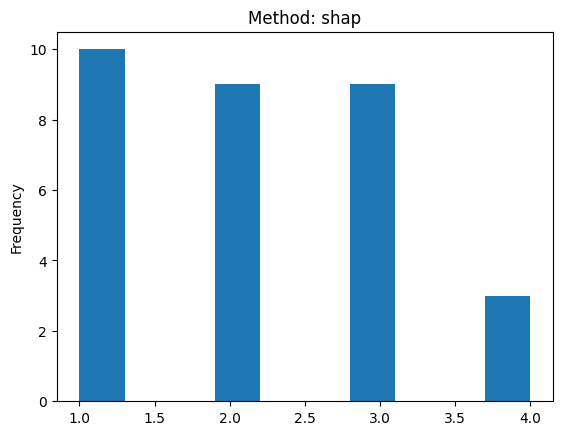

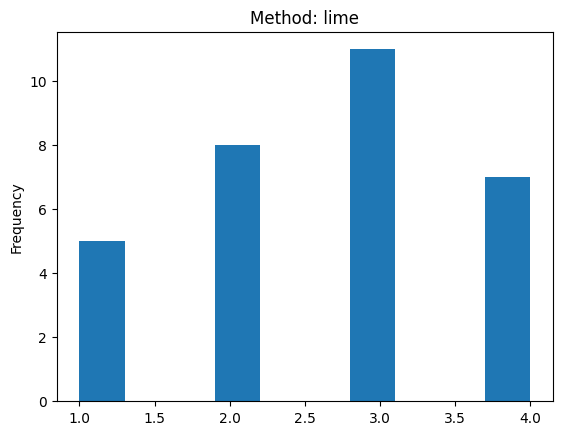

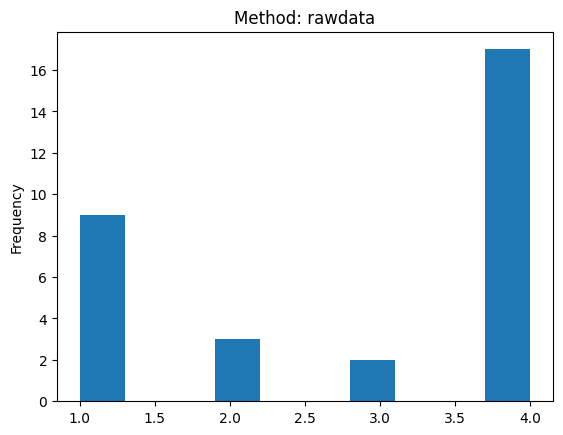

In [115]:
# for each row in auroc_ranks, plot a histogram of the ranks
for i in range(auroc_ranks.shape[0]):
    auroc_ranks.iloc[i].plot(kind="hist")
    plt.title("Method: " + auroc_ranks.index[i])
    plt.show()

    